In [6]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
SEED = 1234
np.random.seed = SEED
random.seed = SEED

## Read in data

In [8]:
# get files
files = glob(f'Data/genres_original/*/*.wav')
random.shuffle(files)
print('File count: ', len(files))
print('Example: ', files[0])

File count:  1000
Example:  Data/genres_original/disco/disco.00006.wav


In [9]:
ipd.Audio(files[0])

## Processing file
1. loading with librosa
2. normalizing audio
3. segmenting audio

In [11]:
y, sr = librosa.load(files[0]) # audio samples and sample rate
print(y.shape) # all data points
print(sr) # sample rate in 1 sec of audio

(661676,)
22050


In [12]:
normalized = librosa.util.normalize(y)
print(f'Before normalization: \n\tmax={np.max(y)} \n\tmin={np.min(y)}')
print(f'After normalization: \n\tmax={np.max(normalized)} \n\tmin={np.min(normalized)}')

Before normalization: 
	max=0.78619384765625 
	min=-0.76593017578125
After normalization: 
	max=1.0 
	min=-0.9742255806922913


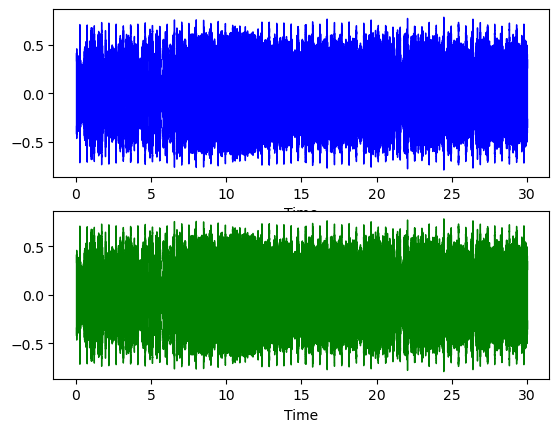

In [13]:
plt.subplot(2,1,1)
librosa.display.waveshow(y, sr=sr, color='b')
plt.subplot(2,1,2)
librosa.display.waveshow(y, sr=sr, color='g')
plt.show()

In [14]:
# segmentation
def segment_audio_data(audio, segment_num=10):
    segment_size = audio.shape[0]//segment_num

    segment_ranges = []
    for i in range(segment_num):
        segment_ranges.append((i*segment_size, (i+1)*segment_size))
    segment_ranges[-1] = (segment_ranges[-1][0], audio.shape[0]+1)
    
    return segment_ranges

segment_num = 10
segment_ranges = segment_audio_data(normalized, segment_num=segment_num)
print('Number of segments: ', segment_num)
print('First segment: ', segment_ranges[0])

Number of segments:  10
First segment:  (0, 66167)


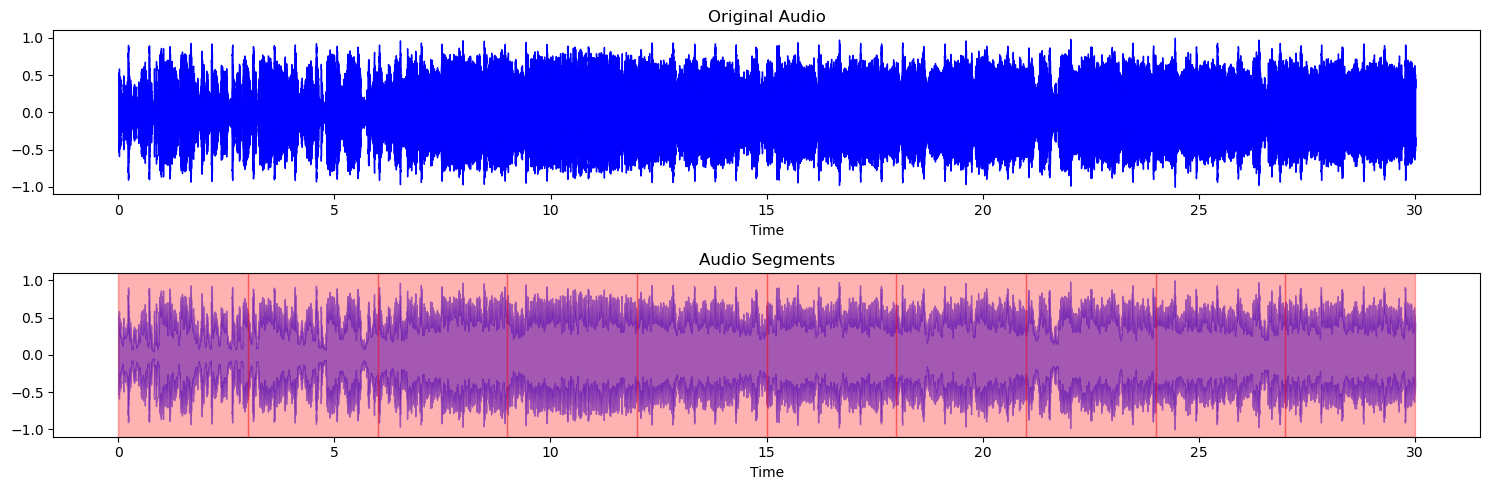

In [15]:
def visualize_audio_segments(audio, sr, segment_ranges):
    plt.figure(figsize=(15, 5))

    # Plot the entire audio waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sr, color='b')
    plt.title('Original Audio')

    # Plot each segment in a different color
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(audio, sr=sr, alpha=0.5, color='b')  # Plot the entire audio as a background

    for start, end in segment_ranges:
        plt.axvspan(start/sr, end/sr, color='r', alpha=0.3)  # Highlight each segment

    plt.title('Audio Segments')
    plt.tight_layout()
    plt.show()

visualize_audio_segments(normalized, sr, segment_ranges)

## Feature extraction
- MFCC
- spectogram
- etc.      

In [18]:
# create features for segments
def get_features(y, segment_ranges):
    df = pd.DataFrame()

    for i, segment_range in enumerate(segment_ranges):
        
        # chroma_stft
        chroma_stft = librosa.feature.chroma_stft(y=y[segment_range[0]:segment_range[1]], sr=sr)
        df.loc[i, 'chroma_stft_mean'] = chroma_stft.mean()
        df.loc[i, 'chroma_stft_var'] = np.var(chroma_stft, axis=1).mean()
        
        # chroma_rms
        chroma_rms = librosa.feature.rms(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'rms_mean'] = chroma_rms.mean()
        df.loc[i, 'rms_var'] = np.var(chroma_rms, axis=1).mean()
        
        # spectral_centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'spectral_centroid_mean'] = spectral_centroid.mean()
        df.loc[i, 'spectral_centroid_var'] = np.var(spectral_centroid, axis=1).mean()
        
        # spectral_bandwidth
        chroma_bandwidth = librosa.feature.spectral_bandwidth(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_bandwidth_mean'] = chroma_bandwidth.mean()
        df.loc[i, 'chroma_bandwidth_var'] = np.var(chroma_bandwidth, axis=1).mean()
        
        # rolloff
        chroma_rolloff = librosa.feature.spectral_rolloff(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_rolloff_mean'] = chroma_rolloff.mean()
        df.loc[i, 'chroma_rolloff_var'] = np.var(chroma_rolloff, axis=1).mean()
        
        # zero_crossing_rate
        chroma_zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_zero_crossing_rate_mean'] = chroma_zero_crossing_rate.mean()
        df.loc[i, 'chroma_zero_crossing_rate_var'] = np.var(chroma_zero_crossing_rate, axis=1).mean()

        # Harmonics and perceptual mean
        chroma_harmony, chroma_perceptr = librosa.effects.hpss(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_harmony_mean'] = chroma_harmony.mean()
        df.loc[i, 'chroma_harmony_var'] = chroma_harmony.var()
        df.loc[i, 'chroma_perceptr_mean'] = chroma_perceptr.mean()
        df.loc[i, 'chroma_perceptr_var'] = chroma_perceptr.var()

        # tempo
        df.loc[i, 'chroma_tempo'], _ = librosa.beat.beat_track(y=y[segment_range[0]:segment_range[1]], sr=sr)
    
        # mfcc
        n_mfcc = 10
        mfcc = librosa.feature.mfcc(y=y[segment_range[0]:segment_range[1]], sr=sr, n_mfcc=n_mfcc)
        for mfcc_idx in range(n_mfcc):
            df.loc[i, 'mffc_mean'+str(mfcc_idx+1)] = mfcc[mfcc_idx].mean()
            df.loc[i, 'mffc_var'+str(mfcc_idx+1)] = mfcc[mfcc_idx].var()
        
    return df
    
# Print the DataFrame
print(get_features(y, segment_ranges).loc[:5])


   chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0          0.448846         0.072493  0.162428  0.002986   
1          0.488363         0.072268  0.172373  0.003326   
2          0.455840         0.063492  0.202344  0.001642   
3          0.448574         0.044220  0.212017  0.000900   
4          0.482807         0.056549  0.193020  0.002202   
5          0.481773         0.058971  0.191722  0.001359   

   spectral_centroid_mean  spectral_centroid_var  chroma_bandwidth_mean  \
0             2846.932392          177437.010830            2501.920240   
1             2926.781131          179085.726620            2495.452504   
2             2731.181347          195771.869215            2387.455688   
3             2447.533767          109246.632649            2238.733962   
4             3082.089963          145088.281705            2649.782594   
5             2870.985572           46248.763474            2522.784557   

   chroma_bandwidth_var  chroma_rolloff_mean  chroma_

## Processing all files

In [19]:
X = []
Y = []

# process all audio files
# Note - expected time to run: ~30min
for i, file in enumerate(files[:20]): # TODO do it for all files
    if i % 50 == 0: print(f'Processed: {i}/{len(files)}')
    try:
        y, sr = librosa.load(file)
        normalized = librosa.util.normalize(y)

        segment_num = 10
        segment_ranges = segment_audio_data(normalized, segment_num=segment_num)

        feature_df = get_features(normalized, segment_ranges)
        X.append(feature_df.to_numpy())
        Y.append(file.split('/')[-2])
    except Exception as e:
        print(f'Exception occured for {file}: ', e)

Processed: 0/1000


In [20]:
X = np.array(X)
print(X.shape)
print('Files processed: ', X.shape[0])
print('Number of segments for a file: ', X.shape[1])
print('Number of features for a file: ', X.shape[2])

(20, 10, 37)
Files processed:  20
Number of segments for a file:  10
Number of features for a file:  37


In [21]:
# convert Y to integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y[:5])
# TODO - convert with to_categorical to a matrix

[3 2 2 8 0]


In [22]:
# split data
train_prec = 0.7
val_prec = 0.15

train_size = int(X.shape[0]*train_prec)
val_size = int(X.shape[0]*val_prec)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (14, 10, 37)
X_val shape:  (3, 10, 37)
X_test shape:  (3, 10, 37)
